In [1]:
import glob
import os
import pickle
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import extq
import prettypyplot as pplt

In [2]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [3]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [4]:
import mdtraj_upside as mu

In [5]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [6]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

In [7]:
figure_dir = "/project/dinner/scguo/kaiB/dga/figures"

In [8]:
n_rep = 48  # replica number

output_names = [
    "gs_d91r",
    "fs_d91r",
    "d91r_05_31",
    "d91r_06_00",
    "remd_d91r_06_00_23_34423",
    "remd_d91r_06_00_19_42383",
    "remd_d91r_06_00_21_33547",
    "remd_d91r_06_00_25_30869",
]
output_dirs = ["gs_p2.5", "fs_p2.5", "05_31", "06_00", "rerun_0", "rerun_1", "rerun_2", "rerun_3"]
work_dir = "/project/dinner/scguo/kaiB/remd/d91r_iso"

In [9]:
heads = [
    "gs_p2.5_gs_p2.5",
    "fs_p2.5_fs_p2.5",
    "05_31_05_31",
    "06_00_06_00",
    "rerun_0_rerun_0",
    "rerun_1_rerun_1",
    "rerun_2_rerun_2",
    "rerun_3_rerun_3",
]

In [10]:
def load_cvs():
    fs_qtots, f_rmsds, p_rmsds, r_rmsds = [], [], [], []
    q_gs_all, q_gs, q_fs_all, q_fs, q_core = [], [], [], [], []

    for d, head in zip(output_dirs, heads):
        fs_qtots.extend(np.load(f"{work_dir}/{d}/outputs/{head}_fs_qtots.pkl", allow_pickle=True))
        f_rmsds.extend(np.load(f"{work_dir}/{d}/outputs/{head}_f_rmsds.pkl", allow_pickle=True))
        p_rmsds.extend(np.load(f"{work_dir}/{d}/outputs/{head}_p_rmsds.pkl", allow_pickle=True))
        r_rmsds.extend(np.load(f"{work_dir}/{d}/outputs/{head}_r_rmsds.pkl", allow_pickle=True))

        q_gs_all.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_gs_all.pkl", allow_pickle=True))
        q_gs.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_gs.pkl", allow_pickle=True))
        q_fs_all.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_fs_all.pkl", allow_pickle=True))
        q_fs.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_fs.pkl", allow_pickle=True))
        q_core.extend(np.load(f"{work_dir}/{d}/outputs/{head}_q_core.pkl", allow_pickle=True))

    fs_qtots = np.asarray([traj[:, start_frame:end_frame:skip] for traj in fs_qtots])
    f_rmsds = np.asarray([traj[start_frame:end_frame:skip] for traj in f_rmsds])
    r_rmsds = np.asarray([traj[start_frame:end_frame:skip] for traj in r_rmsds])
    p_rmsds = np.asarray([traj[start_frame:end_frame:skip] for traj in p_rmsds])

    q_gs_all = np.asarray([traj[start_frame:end_frame:skip] for traj in q_gs_all])
    q_fs_all = np.asarray([traj[start_frame:end_frame:skip] for traj in q_fs_all])
    q_gs = np.asarray([traj[start_frame:end_frame:skip] for traj in q_gs])
    q_fs = np.asarray([traj[start_frame:end_frame:skip] for traj in q_fs])
    q_core = np.asarray([traj[start_frame:end_frame:skip] for traj in q_core])

    return fs_qtots, f_rmsds, p_rmsds, r_rmsds, q_gs_all, q_gs, q_fs_all, q_fs, q_core

In [13]:
def load_hbonds():
    hbonds = []
    for d, n in zip(output_dirs, output_names):
        for i in np.arange(n_rep):
            hbonds.append(
                np.load(f"{work_dir}/{d}/outputs/{i:02}_hb.npy")[start_frame:end_frame:skip]
            )
    return np.array(hbonds)

In [14]:
start_frame = 10000  # skip first _ frames
end_frame = 42000
skip = 1  #

fs_qtots, f_rmsds, p_rmsds, r_rmsds, q_gs_all, q_gs, q_fs_all, q_fs, q_core = load_cvs()
hbonds = load_hbonds()

In [15]:
hbonds.shape

(384, 32000, 86)

In [17]:
weights_all_ts = []
for t in [87, 89, 91]:
    weights = np.load(f"/project/dinner/scguo/kaiB/dga/new_{t}/data/mbar_weights.npy")
    weights_all_ts.append(weights)

In [18]:
c_green = fs_qtots[:, 4] - fs_qtots[:, 5]
c_blue = fs_qtots[:, 6] - fs_qtots[:, 7]
c_orange = fs_qtots[:, 2] - fs_qtots[:, 3]
c_0 = fs_qtots[:, 0] - fs_qtots[:, 1]

In [19]:
cvs = dict(
    blue=c_blue,
    green=c_green,
    orange=c_orange,
    c0=c_0,
    r_rmsd=r_rmsds,
    q_gs_all=q_gs_all,
    q_fs_all=q_fs_all,
    q_core=q_core,
    q_gs=q_gs,
    q_fs=q_fs,
    q_diff=q_fs - q_gs,
)
labels = dict(
    blue=r"$Q_{\mathrm{fs}, \alpha3}-Q_{\mathrm{gs}, \beta4}$",
    green=r"$Q_{\mathrm{fs}, \beta4}-Q_{\mathrm{gs}, \alpha3}$",
    orange=r"$Q_{\mathrm{fs} ,\beta3}-Q_{\mathrm{gs}, \alpha2}$",
    c0=r"$Q_{\mathrm{fs}, \alpha2}-Q_{\mathrm{gs}, \beta3}$",
    r_rmsd=r"N-term RMSD (nm)",
    q_gs_all=r"$Q_{\mathrm{gs}}$",
    q_fs_all=r"$Q_{\mathrm{fs}}$",
    q_gs=r"$Q_{\mathrm{gs, C}}$",
    q_fs=r"$Q_{\mathrm{fs, C}}$",
    q_core=r"$Q_{\mathrm{N}}$",
    q_diff=r"$Q_{\mathrm{fs, C}}-Q_{\mathrm{gs, C}}$",
    qp=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$",
)
lims = dict(
    blue=(-1.3, 1),
    green=(-1, 1.3),
    orange=(-1, 1.3),
    c0=(-1.3, 1),
    r_rmsd=(0, 1.2),
    q_gs_all=(0, 1),
    q_fs_all=(0, 1),
    q_gs=(0, 1),
    q_fs=(0, 1),
    q_core=(0, 1),
    q_diff=(-1, 1),
    qp=(0, 1),
)

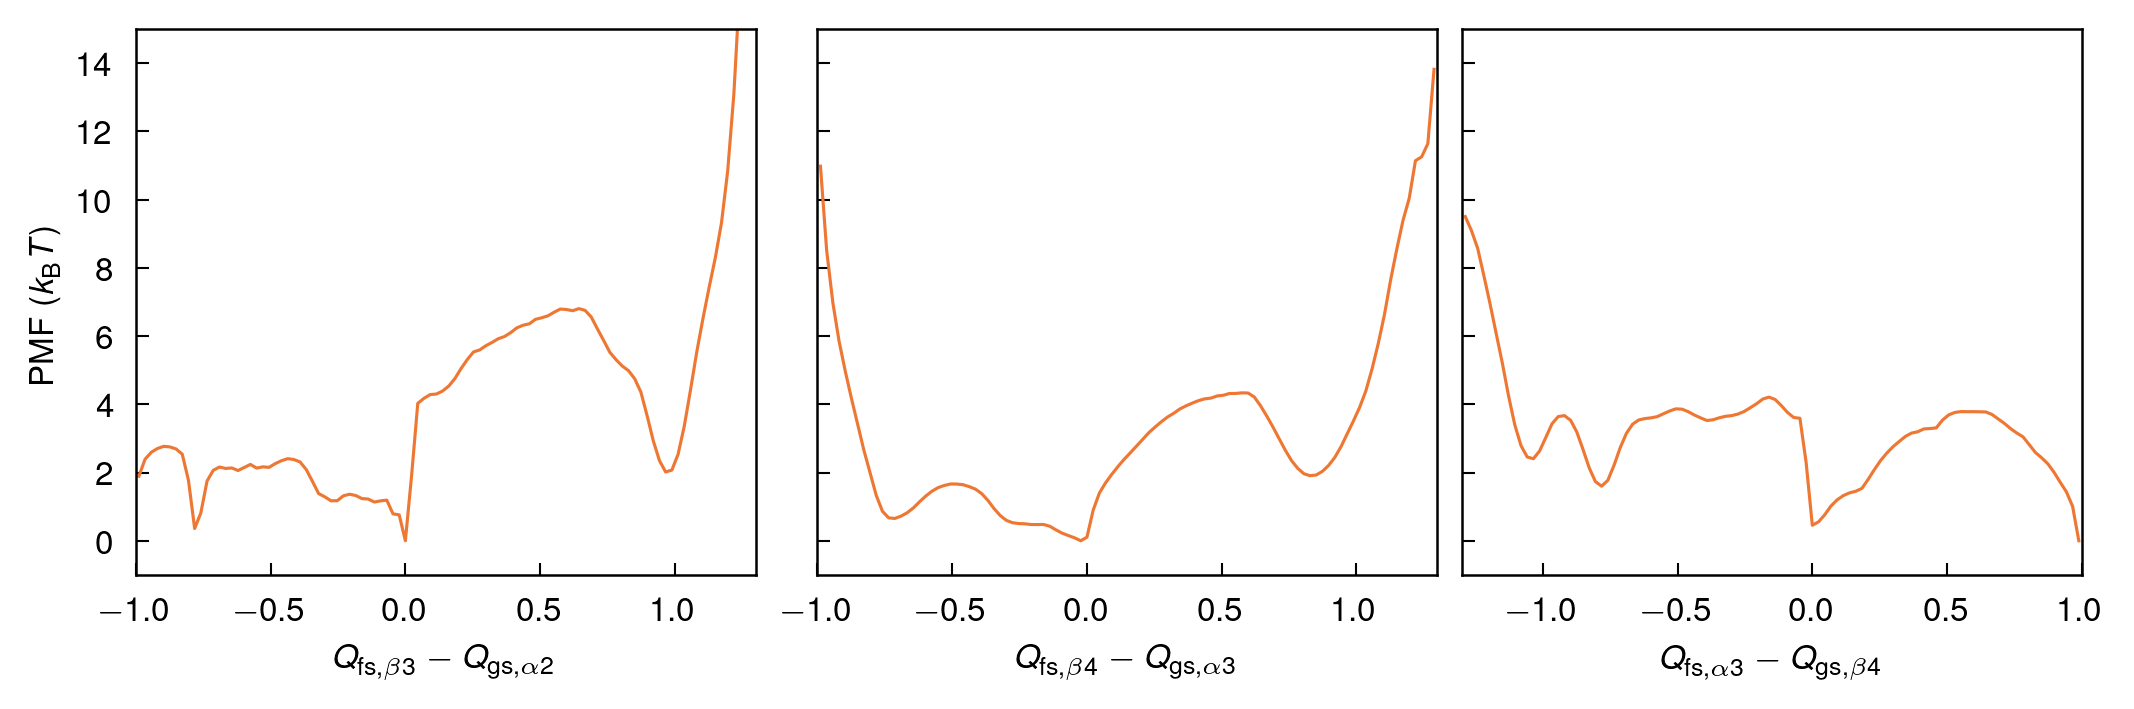

In [20]:
# plot PMFs of different cvs
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharey=True, constrained_layout=True)

for ax, cv in zip(axes, ["orange", "green", "blue"]):
    xe = np.linspace(*lims[cv], 101)
    xc = (xe[1:] + xe[:-1]) / 2
    hist = extq.projection.density1d(cvs[cv], weights_all_ts[0], xe)
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    ax.plot(xc, pmf)
    ax.set_xlabel(labels[cv])
    ax.set_ylabel(r"PMF ($k_{\mathrm{B}}T$)")
    ax.label_outer()
    ax.set_xlim(*lims[cv])
    ax.set_ylim([-1, 15])

/scratch/local/jobs/20766144/ipykernel_1476810/1259005292.py:13: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


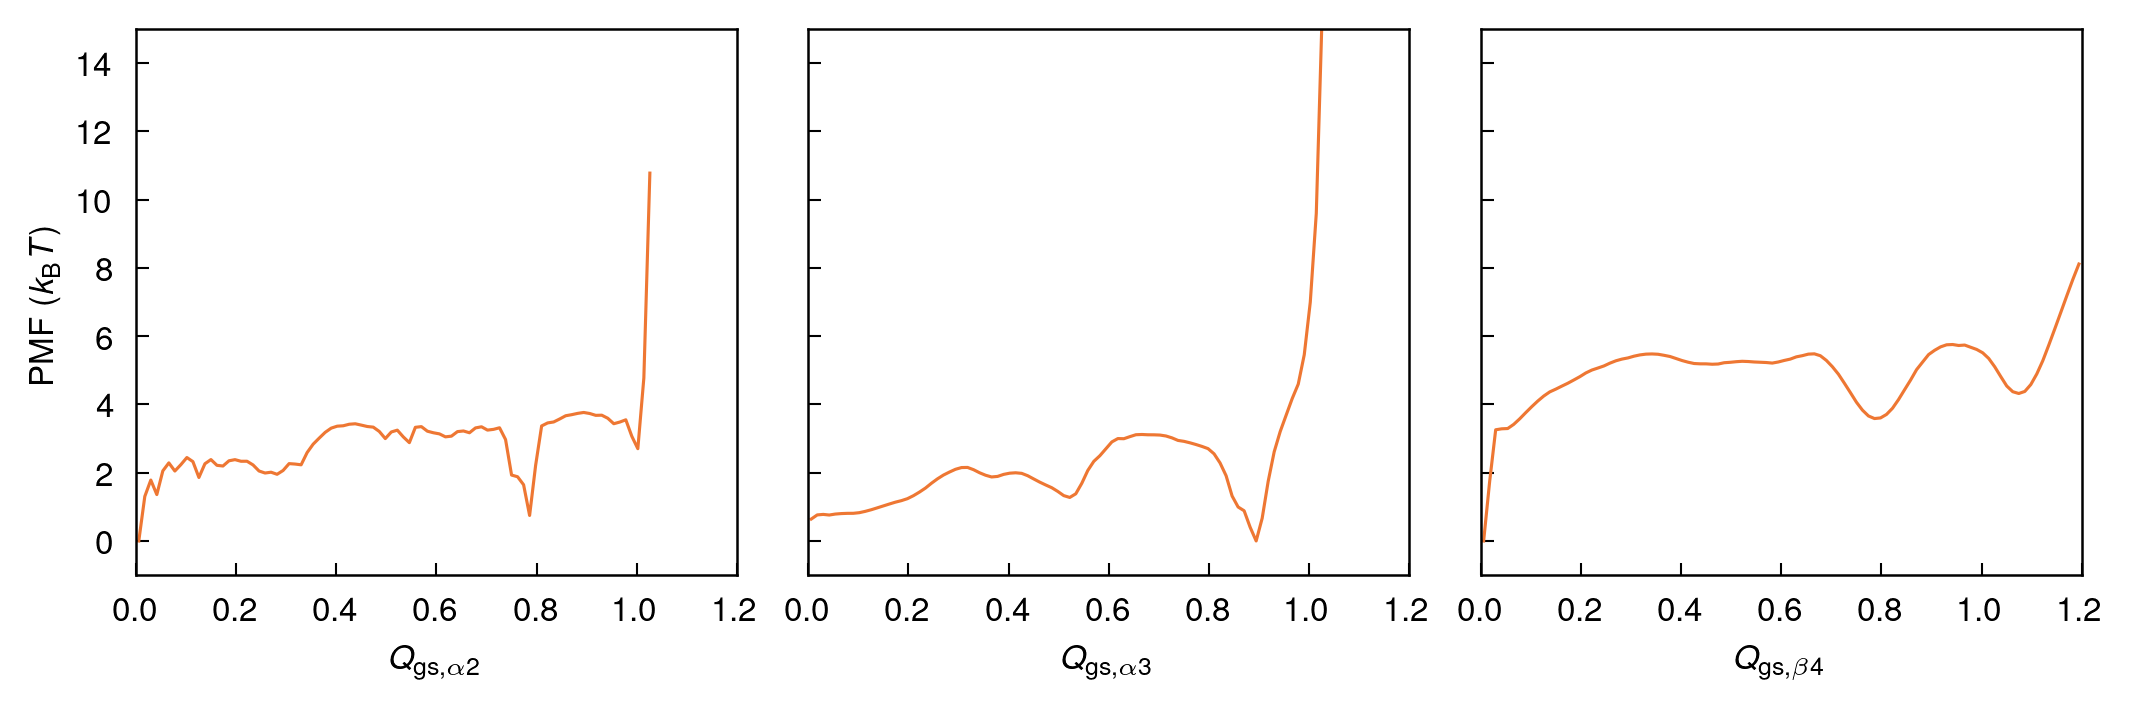

In [21]:
# plot PMFs of different cvs
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharey=True, constrained_layout=True)

for ax, cv, name in zip(
        axes,
        fs_qtots[:, 3::2].swapaxes(0, 1),
        [r"$Q_{\mathrm{gs},\alpha2}$", r"$Q_{\mathrm{gs},\alpha3}$", r"$Q_{\mathrm{gs},\beta4}$"]
    ):
    xe = np.linspace(0, 1.2, 101)
    xc = (xe[1:] + xe[:-1]) / 2
    hist = extq.projection.density1d(cv, weights_all_ts[0], xe)
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    ax.plot(xc, pmf)
    ax.set_xlabel(name)
    ax.set_ylabel(r"PMF ($k_{\mathrm{B}}T$)")
    ax.label_outer()
    ax.set_xlim([0, 1.2])
    ax.set_ylim([-1, 15])

/scratch/local/jobs/20766144/ipykernel_1476810/744571729.py:13: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


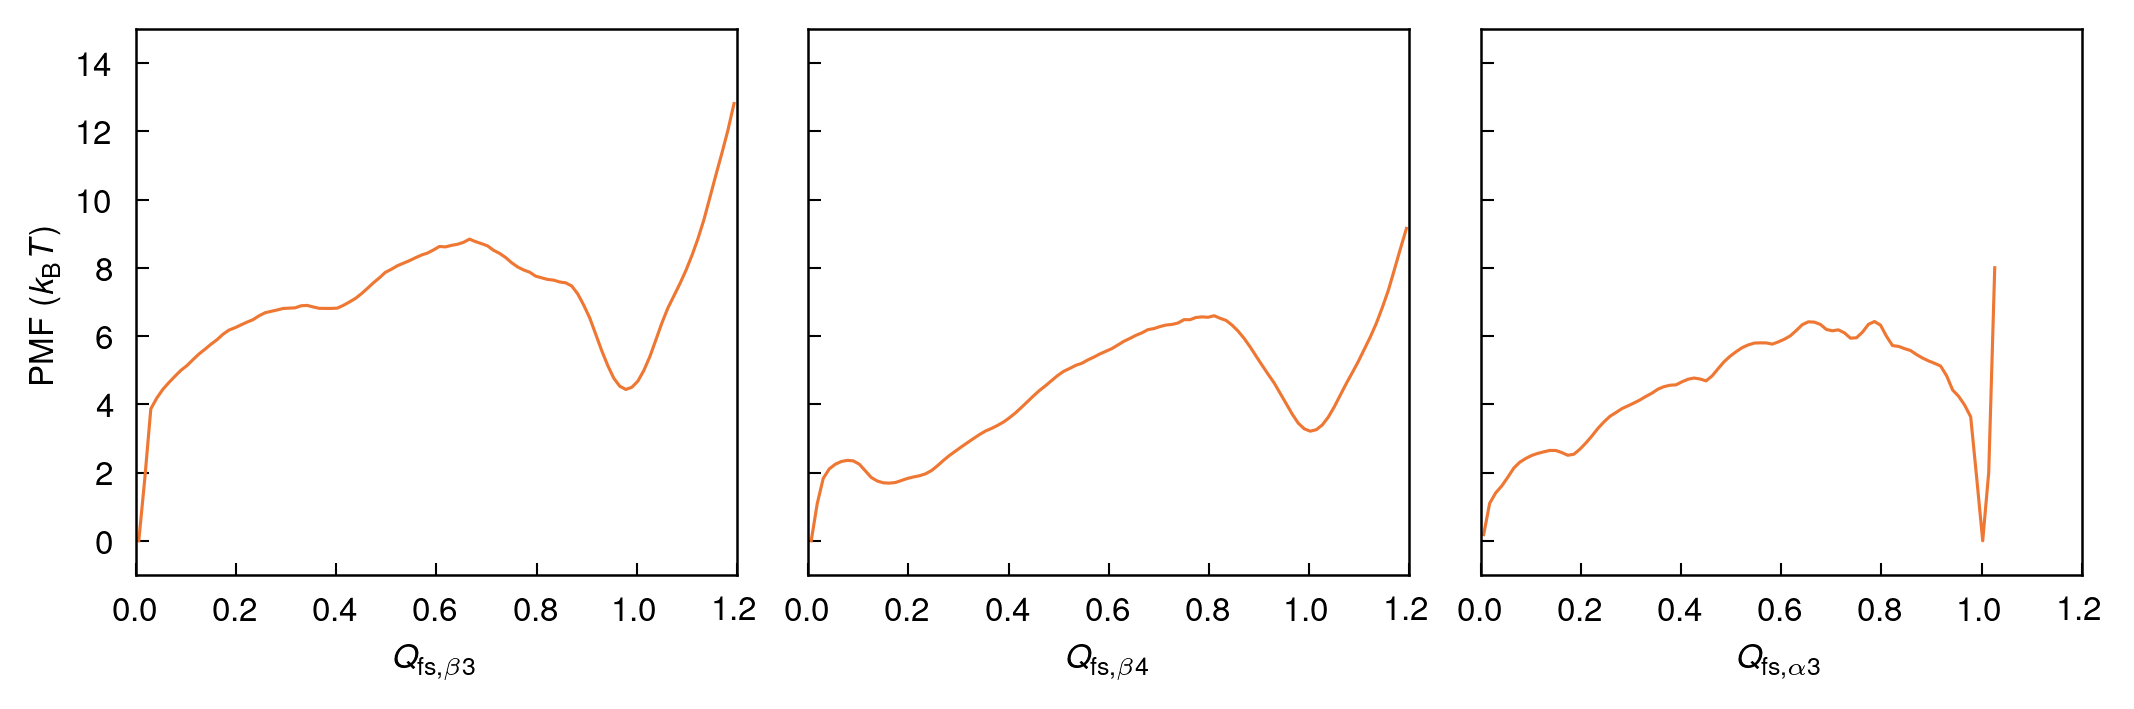

In [22]:
# plot PMFs of different cvs
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharey=True, constrained_layout=True)

for ax, cv, name in zip(
        axes,
        fs_qtots[:, 2::2].swapaxes(0, 1),
        [r"$Q_{\mathrm{fs},\beta3}$", r"$Q_{\mathrm{fs},\beta4}$", r"$Q_{\mathrm{fs},\alpha3}$"]
    ):
    xe = np.linspace(0, 1.2, 101)
    xc = (xe[1:] + xe[:-1]) / 2
    hist = extq.projection.density1d(cv, weights_all_ts[0], xe)
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    ax.plot(xc, pmf)
    ax.set_xlabel(name)
    ax.set_ylabel(r"PMF ($k_{\mathrm{B}}T$)")
    ax.label_outer()
    ax.set_xlim([0, 1.2])
    ax.set_ylim([-1, 15])

In [26]:
donor_ids = np.loadtxt(f"{work_dir}/donor_resid.txt", dtype=int)

In [28]:
donor_ids

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
       93])

In [40]:
arr_ids = []
for i in range(9, 14):
    arr_ids.append(np.nonzero(donor_ids == i)[0])
arr_ids = np.array(arr_ids).squeeze()

In [114]:
# which trajectory with gs beta4 near 0.8?
for k in np.argsort(np.mean((fs_qtots[:, 7]  - 0.8)**2, axis=-1))[:5]:
    i, j = divmod(k, 48)
    print(output_dirs[i], j)
    traj = mu.load_upside_traj(f"{work_dir}/{output_dirs[i]}/{output_names[i]}.run.{j:02}.up")
    traj.save(f"{work_dir}/{output_dirs[i]}/{output_names[i]}.run.{j:02}.xtc")

05_31 19
05_31 18
05_31 15
05_31 17
05_31 20


In [115]:
for k in np.argsort(np.mean((fs_qtots[:, 7]  - 0.8)**2, axis=-1))[:5]:
    i, j = divmod(k, 48)
    print(np.argsort(cvs['q_gs_all'][j])[:10])

[31293 22745 22824 11805 10190 10189 14272 10133 10202 13601]
[31267 24227 12144 13571 10985 13641 13824 10392 13720 29902]
[13718 28401 13822 10384 28400 28051 30951  9888 28433 29414]
[22823 10285 10900 28386 10249 30557 13816 10525 30805 10390]
[14164 24226 22603 20704 20741 22723 13478 13731 11797 31712]


In [42]:
k

116

In [45]:
def smoothed(arr, w=100):
    return scipy.signal.convolve(arr, np.ones(w) / w, mode='same')

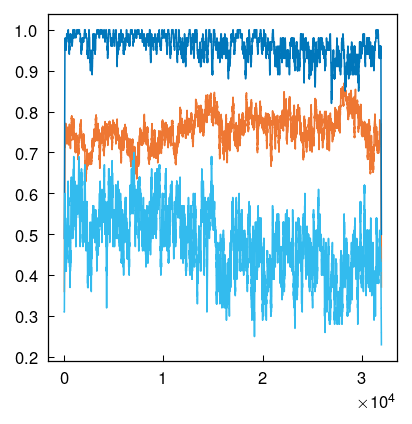

In [53]:
plt.plot(smoothed(fs_qtots[116, 7]))
plt.plot(smoothed(hbonds[116, :, donor_ids == 13].squeeze()))
plt.plot(smoothed(hbonds[116, :, donor_ids == 15].squeeze()))
# plt.plot(smoothed(hbonds[116, :, donor_ids == 88].squeeze()))

In [54]:
weights.shape

(384, 32000)

In [75]:
# mean donor occupancy
occupancies = []
donors = [9, 10, 11, 12, 13, 87, 88, 89, 90, 91, 92, 93]
weight_normed = weights / np.sum(weights)
for donor in donors:
    occupancies.append(np.mean(hbonds[..., donor_ids == donor].squeeze() * weight_normed))

Text(0, 0.5, 'Hydrogen bonding donor frequency')

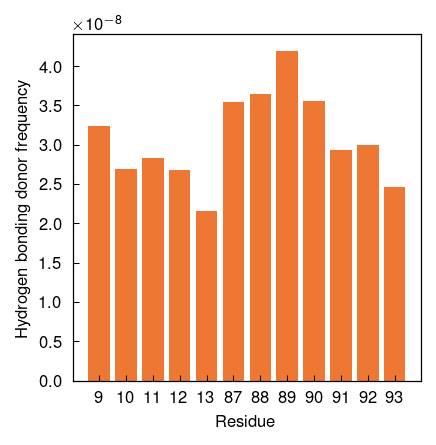

In [76]:
plt.bar(np.arange(len(donors)), occupancies)
plt.xticks(np.arange(len(donors)), donors)
plt.xlabel("Residue")
plt.ylabel("Hydrogen bonding donor frequency")

In [101]:
# normal beta sheet
def define_sheet(hbonds, donors, not_donors):
    bool_arr = np.zeros([len(donors), *hbonds[..., 0].shape])
    bool_arr2 = np.zeros([len(not_donors), *hbonds[..., 0].shape])
    for i, d in enumerate(donors):
        bool_arr[i] = hbonds[..., donor_ids == d].squeeze()
    for i, d in enumerate(not_donors):
        bool_arr2[i] = hbonds[..., donor_ids == d].squeeze()
    return np.logical_and.reduce(bool_arr) & np.logical_and.reduce(np.logical_not(bool_arr2))

In [102]:
normal_beta_donors = np.array([9, 11, 13, 89, 91, 93])
normal_beta = define_sheet(hbonds, normal_beta_donors, [87])
shifted_beta_donors = np.array([9, 11, 13, 87, 89, 91])
shifted_beta = define_sheet(hbonds, shifted_beta_donors, [93])

In [103]:
print(np.mean(normal_beta * weights))
print(np.mean(shifted_beta * weights))

0.0004054980485433779
0.0020975903068418886


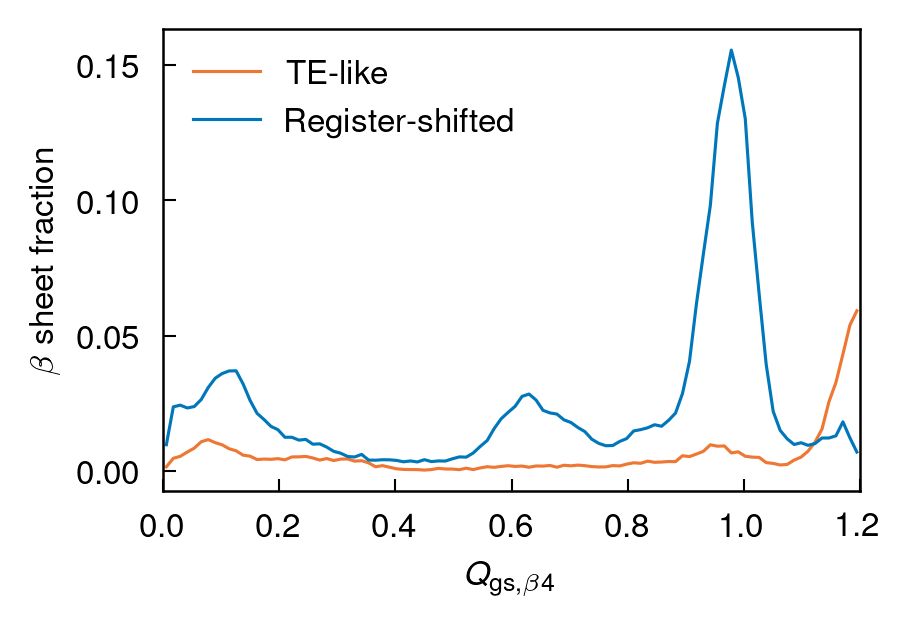

In [104]:
fig = plt.figure(figsize=(3, 2), dpi=300)
ax = plt.gca()
xe = np.linspace(0, 1.2, 101)
xc = (xe[1:] + xe[:-1]) / 2
hist = extq.projection.average1d(fs_qtots[:, 7, :], normal_beta, weights_all_ts[0], xe)
hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
ax.plot(xc, hist, label="TE-like")

hist = extq.projection.average1d(fs_qtots[:, 7, :], shifted_beta, weights_all_ts[0], xe)
hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
ax.plot(xc, hist, label="Register-shifted")

ax.set_xlabel(r"$Q_{\mathrm{gs},\beta4}$")
ax.set_ylabel(r"$\beta$ sheet fraction")
ax.label_outer()
ax.set_xlim([0, 1.2])
pplt.legend()
# ax.set_ylim([-1, 15])

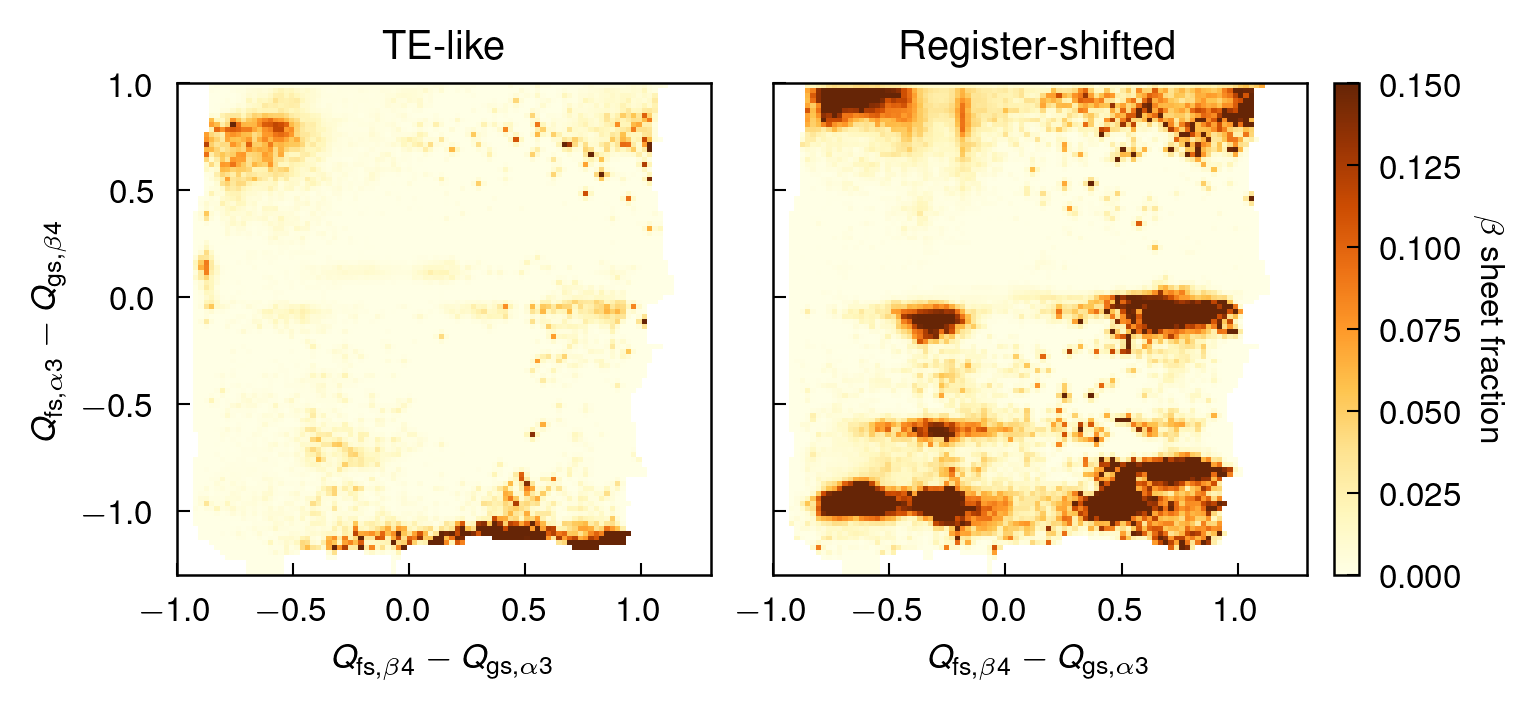

In [106]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(5, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "green"
cv2 = "blue"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
cv1_delay = cvs[cv1]
cv2_delay = cvs[cv2]

hist = extq.projection.average2d(
    cv1_delay,
    cv2_delay,
    normal_beta,
    weights,
    xe,
    ye,
)
hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
pc = axes[0].pcolormesh(xc, yc, hist.T, cmap="YlOrBr", vmax=0.15, rasterized=True)
hist = extq.projection.average2d(
    cv1_delay,
    cv2_delay,
    shifted_beta,
    weights,
    xe,
    ye,
)
hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
pc = axes[1].pcolormesh(xc, yc, hist.T, cmap="YlOrBr", vmax=0.15, rasterized=True)

axes[0].set_title("TE-like")
axes[1].set_title("Register-shifted")
for ax in axes:
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label=r"$\beta$ sheet fraction", rotation=-90, labelpad=10)

In [107]:
normal_beta_gs = normal_beta & (cvs['q_diff'] < -0.5)
shifted_beta_gs = shifted_beta & (cvs['q_diff'] < -0.5)

In [108]:
print(np.mean(normal_beta_gs * weights))
print(np.mean(shifted_beta_gs * weights))

7.4283227057721995e-06
0.00011307682314742538


In [110]:
for k in np.argsort(np.sum(shifted_beta_gs, axis=-1))[:-5:-1]:
    i, j = divmod(k, 48)
    print(output_dirs[i], j)
    traj = mu.load_upside_traj(f"{work_dir}/{output_dirs[i]}/{output_names[i]}.run.{j:02}.up")
    traj.save(f"{work_dir}/{output_dirs[i]}/{output_names[i]}.run.{j:02}.xtc")

gs_p2.5 25
gs_p2.5 24
gs_p2.5 23
gs_p2.5 22


In [122]:
for k in np.argsort(np.sum(shifted_beta_gs, axis=-1))[:-5:-1]:
    i, j = divmod(k, 48)
    print(output_dirs[i], j)
    print(np.argsort(cvs['q_gs_all'][k])[:-10:-1])

gs_p2.5 25
[ 6817 29321 15610  4947 15601 13184   768  6893 22670]
gs_p2.5 24
[13323  6793 13329 29521  1466  4992  2486  6798 29585]
gs_p2.5 23
[ 2963 29404  2074  1570 15602 15609  2362  1457 25000]
gs_p2.5 22
[ 5187  5066 16661  4949  1712  1971  2976 13254 16650]


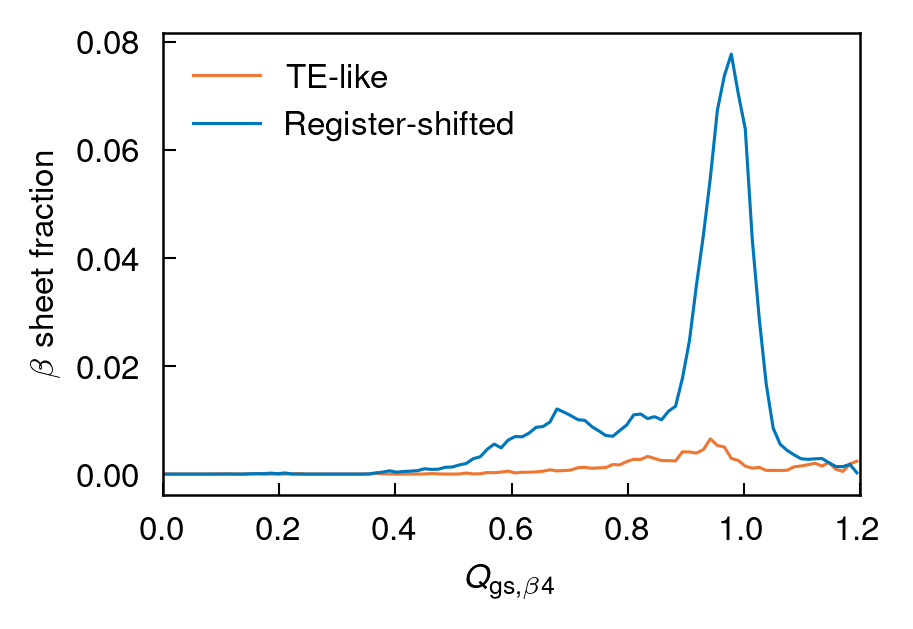

In [109]:
fig = plt.figure(figsize=(3, 2), dpi=300)
ax = plt.gca()
xe = np.linspace(0, 1.2, 101)
xc = (xe[1:] + xe[:-1]) / 2
hist = extq.projection.average1d(fs_qtots[:, 7, :], normal_beta_gs, weights_all_ts[0], xe)
hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
ax.plot(xc, hist, label="TE-like")

hist = extq.projection.average1d(fs_qtots[:, 7, :], shifted_beta_gs, weights_all_ts[0], xe)
hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
ax.plot(xc, hist, label="Register-shifted")

ax.set_xlabel(r"$Q_{\mathrm{gs},\beta4}$")
ax.set_ylabel(r"$\beta$ sheet fraction")
ax.label_outer()
ax.set_xlim([0, 1.2])
pplt.legend()
# ax.set_ylim([-1, 15])

/project/dinner/scguo/extq/src/extq/projection.py:145: RuntimeWarning: invalid value encountered in divide
  return numer / denom


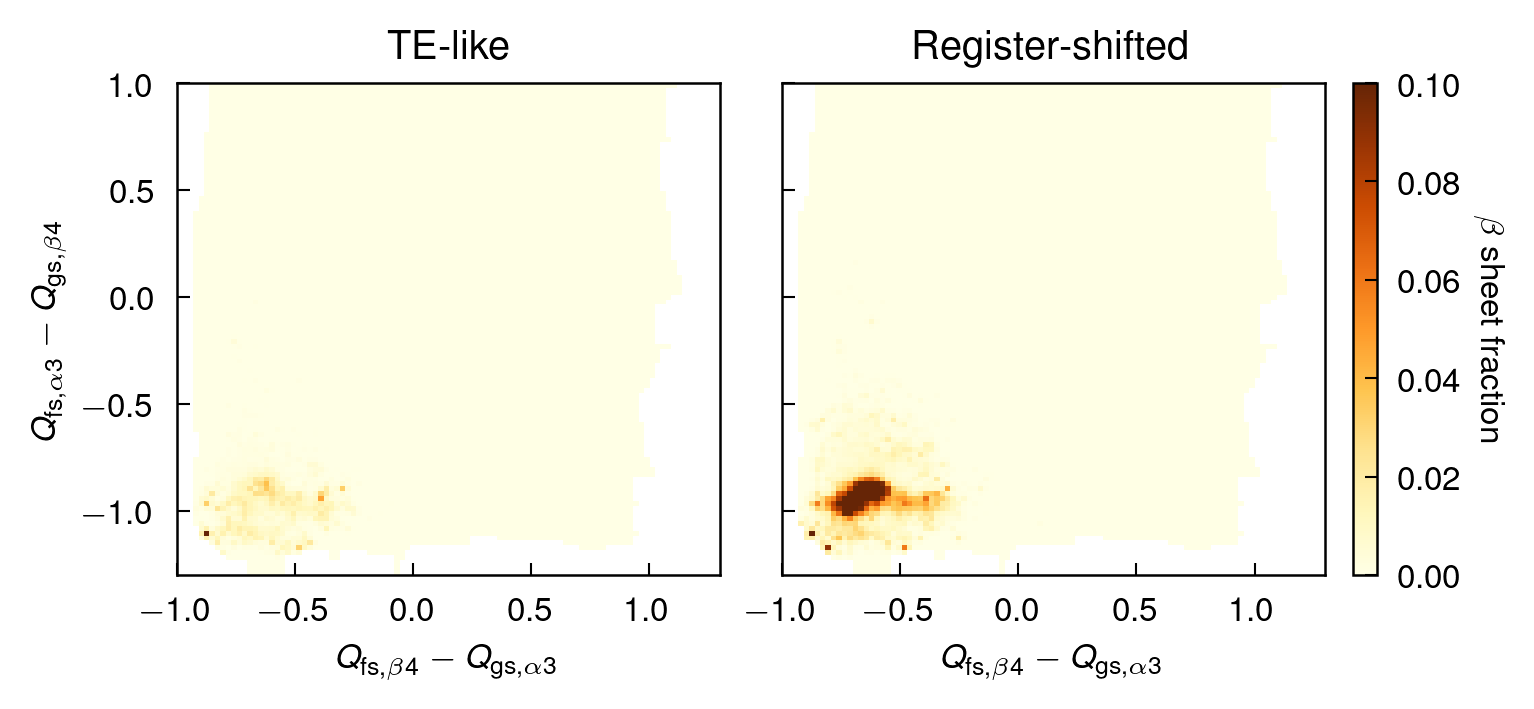

In [95]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(5, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "green"
cv2 = "blue"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
cv1_delay = cvs[cv1]
cv2_delay = cvs[cv2]

hist = extq.projection.average2d(
    cv1_delay,
    cv2_delay,
    normal_beta_gs,
    weights,
    xe,
    ye,
)
hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
pc = axes[0].pcolormesh(xc, yc, hist.T, cmap="YlOrBr", vmax=0.1, rasterized=True)
hist = extq.projection.average2d(
    cv1_delay,
    cv2_delay,
    shifted_beta_gs,
    weights,
    xe,
    ye,
)
hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
pc = axes[1].pcolormesh(xc, yc, hist.T, cmap="YlOrBr", vmax=0.1, rasterized=True)

axes[0].set_title("TE-like")
axes[1].set_title("Register-shifted")
for ax in axes:
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label=r"$\beta$ sheet fraction", rotation=-90, labelpad=10)